# Import

In [4]:
%reload_ext autoreload
%autoreload 2

In [28]:
import matplotlib.pyplot as plt
import missingno as mno
import numpy as np
import pandas as pd
import seaborn as sns
import warnings

from pathlib import Path
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

from utils.plotsettings import settings
from utils.preprocessing import customer_preprocessing


%matplotlib inline
warnings.filterwarnings("ignore")
settings()

In [19]:
data_path = Path("../data/")

# Extract orders, payments, reviews, and customers data
orders = pd.read_csv(data_path / "csv" / "orders.csv").drop(
    ["index", "order_approved_at", "order_delivered_carrier_date"],
    axis=1
)
payments = pd.read_csv(data_path / "csv" / "payments.csv").drop(
    ["index", "payment_installments", "payment_sequential", "payment_type"],
    axis=1
)
reviews = pd.read_csv(data_path / "csv" / "reviews.csv").drop(
    [
        "index",
        "review_id",
        "review_answer_timestamp",
        "review_comment_title",
        "review_comment_message",
        "review_creation_date",
    ],
    axis=1,
)
customers = pd.read_csv(data_path / "csv" / "customers.csv").drop(
    ["index", "customer_state", "customer_zip_code_prefix", "customer_city"],
    axis=1
)

# Outer join

In [7]:
# Merge all dataframes with outer join to gather all available information
df = (
    orders.merge(payments, how="outer", on="order_id")
    .merge(reviews, how="outer", on="order_id") 
    .merge(customers, how="outer", on="customer_id")
).drop("customer_id", axis=1)

df.head()

,order_id,order_status,order_purchase_timestamp,order_delivered_customer_date,order_estimated_delivery_date,payment_value,review_score,customer_unique_id
0,5f79b5b0931d63f1a42989eb65b9da6e,delivered,2017-11-14 16:08:26,2017-11-28 15:41:30,2017-12-04 00:00:00,114.74,1.0,248ffe10d632bebe4f7267f1f44844c9
1,a44895d095d7e0702b6a162fa2dbeced,delivered,2017-07-16 09:40:32,2017-07-25 18:57:33,2017-08-04 00:00:00,67.41,4.0,b0015e09bb4b6e47c52844fab5fb6638
2,316a104623542e4d75189bb372bc5f8d,delivered,2017-02-28 11:06:43,2017-03-06 08:57:49,2017-03-22 00:00:00,195.42,5.0,94b11d37cd61cb2994a194d11f89682b
3,5825ce2e88d5346438686b0bba99e5ee,delivered,2017-08-16 13:09:20,2017-09-13 20:06:02,2017-09-14 00:00:00,179.35,5.0,4893ad4ea28b2c5b3ddf4e82e79db9e6
4,0ab7fb08086d4af9141453c91878ed7a,delivered,2018-04-02 13:42:17,2018-04-13 20:21:08,2018-04-18 00:00:00,107.01,4.0,0b83f73b19c2019e182fd552c048a22c


In [8]:
# Sort the orders by historical order
df.sort_values("order_purchase_timestamp")

,order_id,order_status,order_purchase_timestamp,order_delivered_customer_date,order_estimated_delivery_date,payment_value,review_score,customer_unique_id
3511,2e7a8482f6fb09756ca50c10d7bfc047,shipped,2016-09-04 21:15:19,NaN,2016-10-20 00:00:00,136.23,1.0,b7d76e111c89f7ebf14761390f0f7d17
42398,e5fa5a7210941f7d56d0208e4e071d35,canceled,2016-09-05 00:15:34,NaN,2016-10-28 00:00:00,75.06,1.0,4854e9b3feff728c13ee5fc7d1547e92
39992,809a282bbd5dbcabb6f2f724fca862ec,canceled,2016-09-13 15:24:19,NaN,2016-09-30 00:00:00,40.95,1.0,009b0127b727ab0ba422f6d9604487c7
55027,bfbd0f9bdef84302105ad712db648a6c,delivered,2016-09-15 12:16:38,2016-11-09 07:47:38,2016-10-04 00:00:00,NaN,1.0,830d5b7aaa3b6f1e9ad63703bec97d23
72487,71303d7e93b399f5bcd537d124c0bcfa,canceled,2016-10-02 22:07:52,NaN,2016-10-25 00:00:00,109.34,1.0,0eb1ee9dba87f5b36b4613a65074337c
...,...,...,...,...,...,...,...,...
16474,392ed9afd714e3c74767d0c4d3e3f477,canceled,2018-09-29 09:13:03,NaN,2018-10-15 00:00:00,137.03,1.0,9bb92bebd4cb7511e1a02d5e50bc4655
78454,616fa7d4871b87832197b2a137a115d2,canceled,2018-10-01 15:30:09,NaN,2018-10-23 00:00:00,80.38,2.0,634420a0ea42302205032ed44ac7fccc
31063,a2ac6dad85cf8af5b0afb510a240fe8c,canceled,2018-10-03 18:55:29,NaN,2018-10-16 00:00:00,197.55,1.0,af5454198a97379394cacf676e1e96cb
54416,b059ee4de278302d550a3035c4cdb740,canceled,2018-10-16 20:16:02,NaN,2018-11-12 00:00:00,222.03,5.0,262e1f1e26e92e86375f86840b4ffd63


# Conversion datetime

In [9]:
# Convert the date columns to datetime format
for dt in [
    "order_purchase_timestamp",
    "order_delivered_customer_date",
    "order_estimated_delivery_date",
]:
    df[dt] = pd.to_datetime(df[dt])

# EDA

<Axes: >

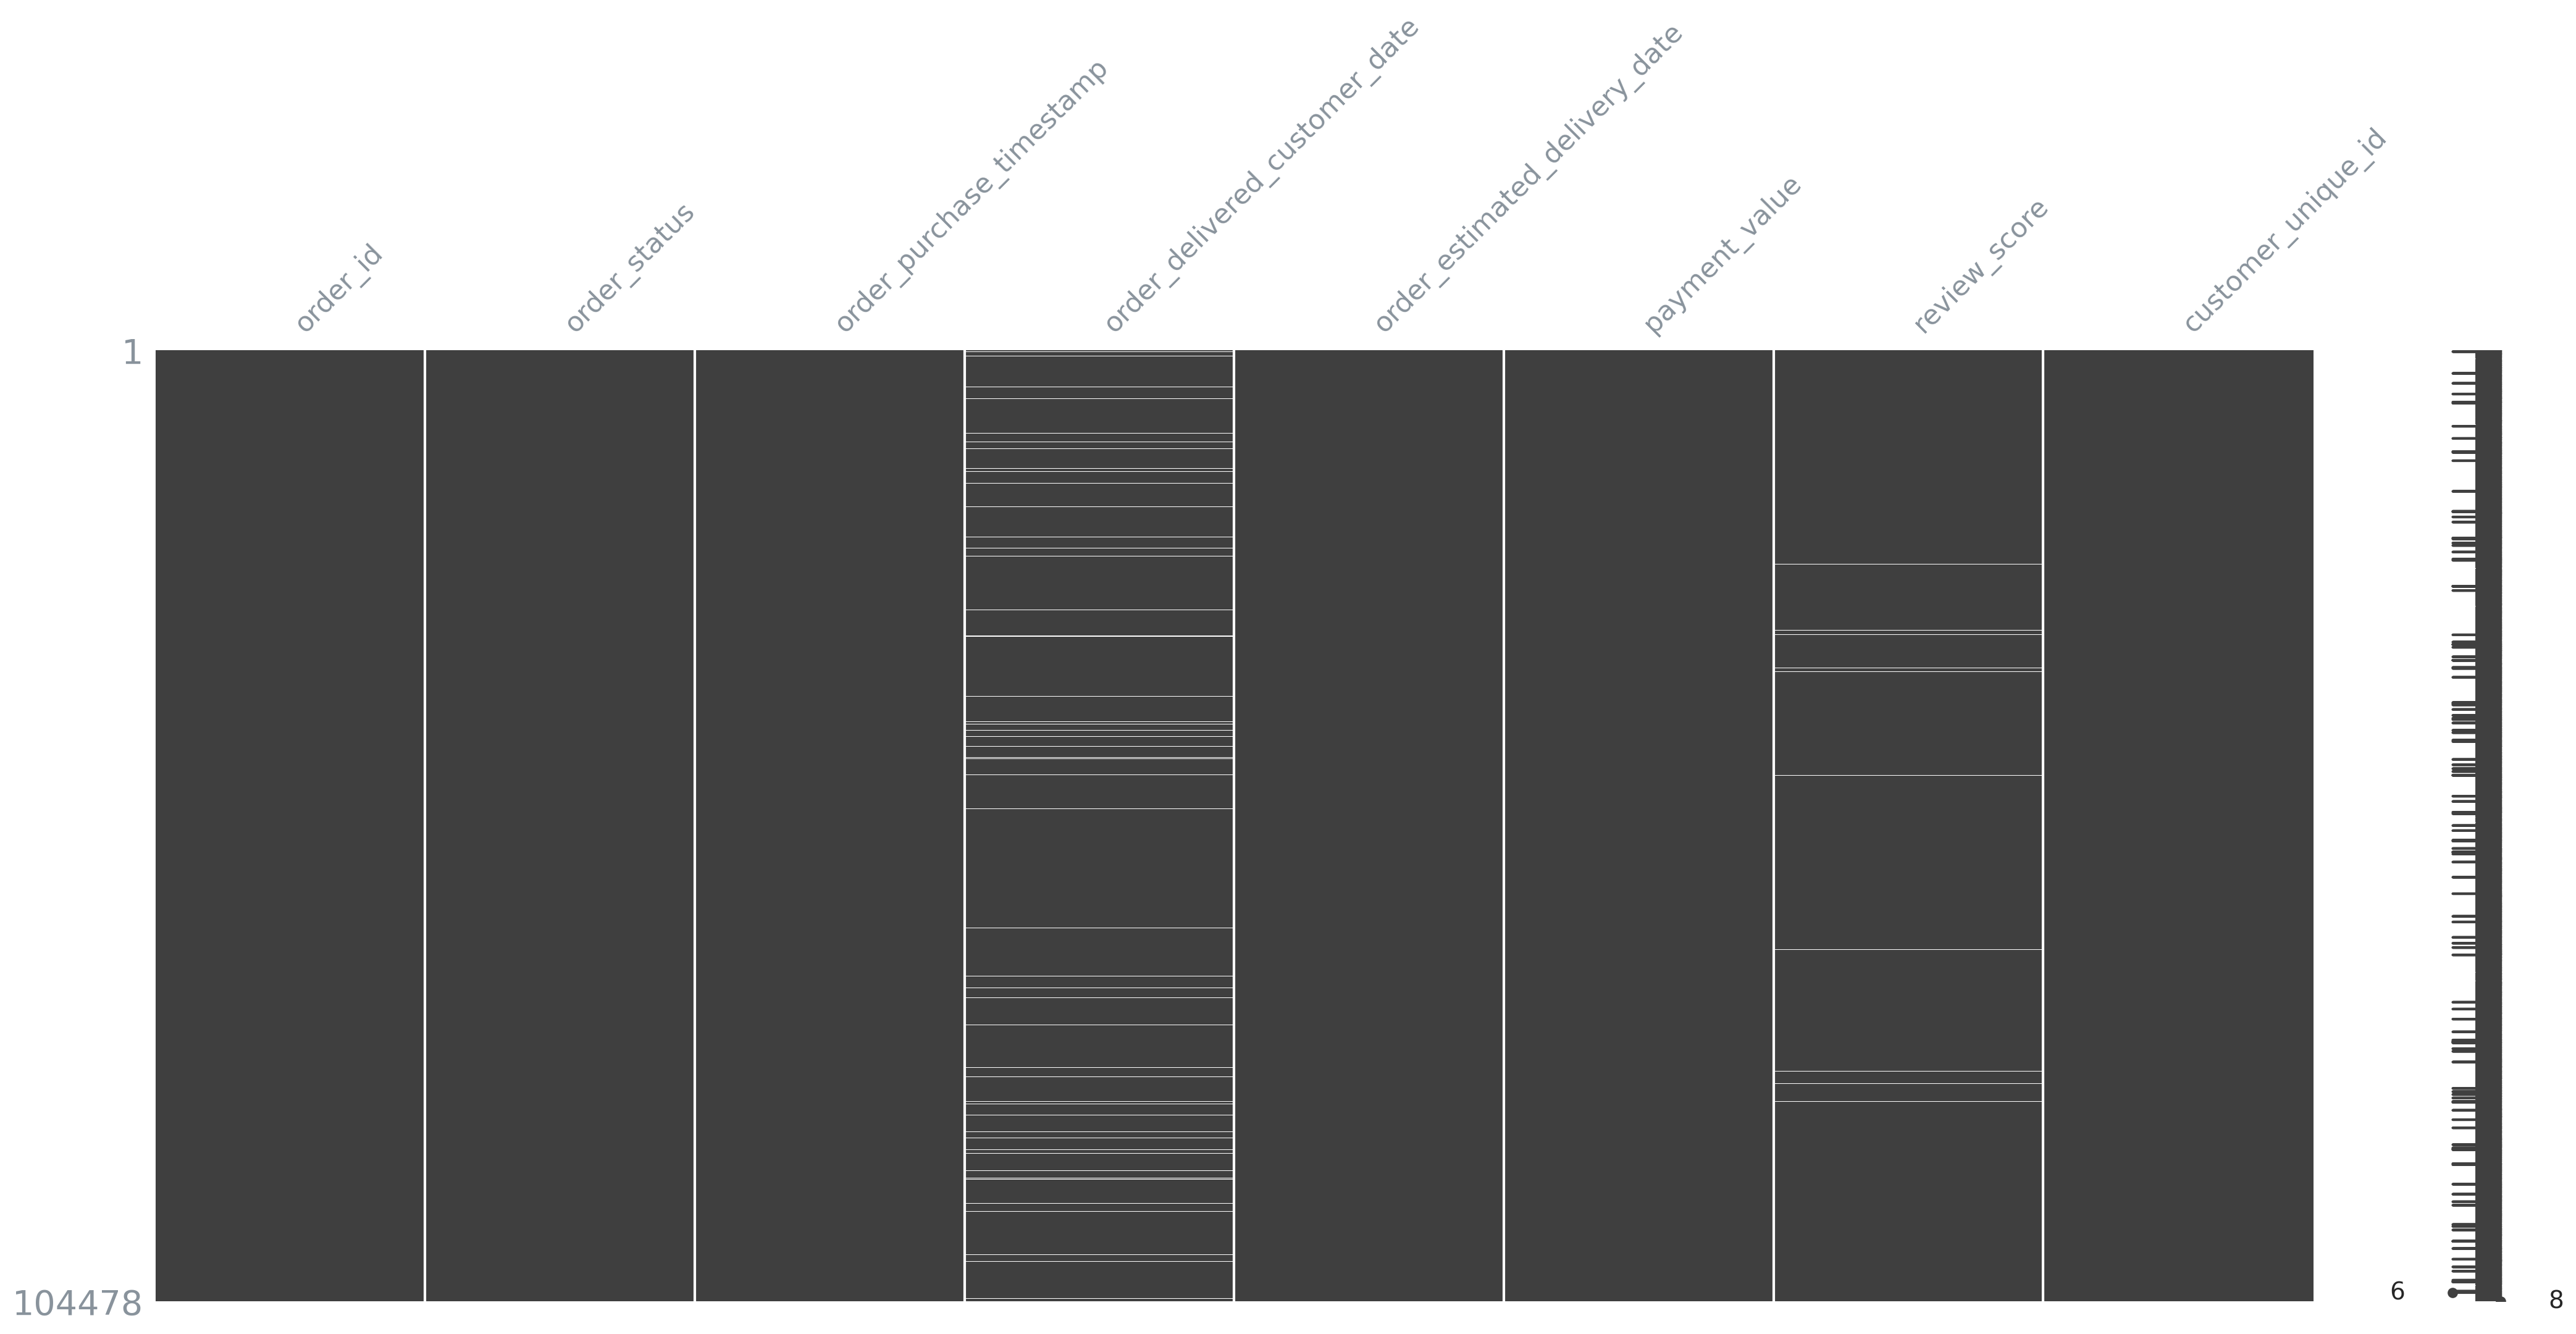

In [8]:
# Check for missing values
mno.matrix(df)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104478 entries, 0 to 104477
Data columns (total 8 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       104478 non-null  object        
 1   order_status                   104478 non-null  object        
 2   order_purchase_timestamp       104478 non-null  datetime64[ns]
 3   order_delivered_customer_date  101324 non-null  datetime64[ns]
 4   order_estimated_delivery_date  104478 non-null  datetime64[ns]
 5   payment_value                  104477 non-null  float64       
 6   review_score                   103678 non-null  float64       
 7   customer_unique_id             104478 non-null  object        
dtypes: datetime64[ns](3), float64(2), object(3)
memory usage: 6.4+ MB


### Distributions of key metrics

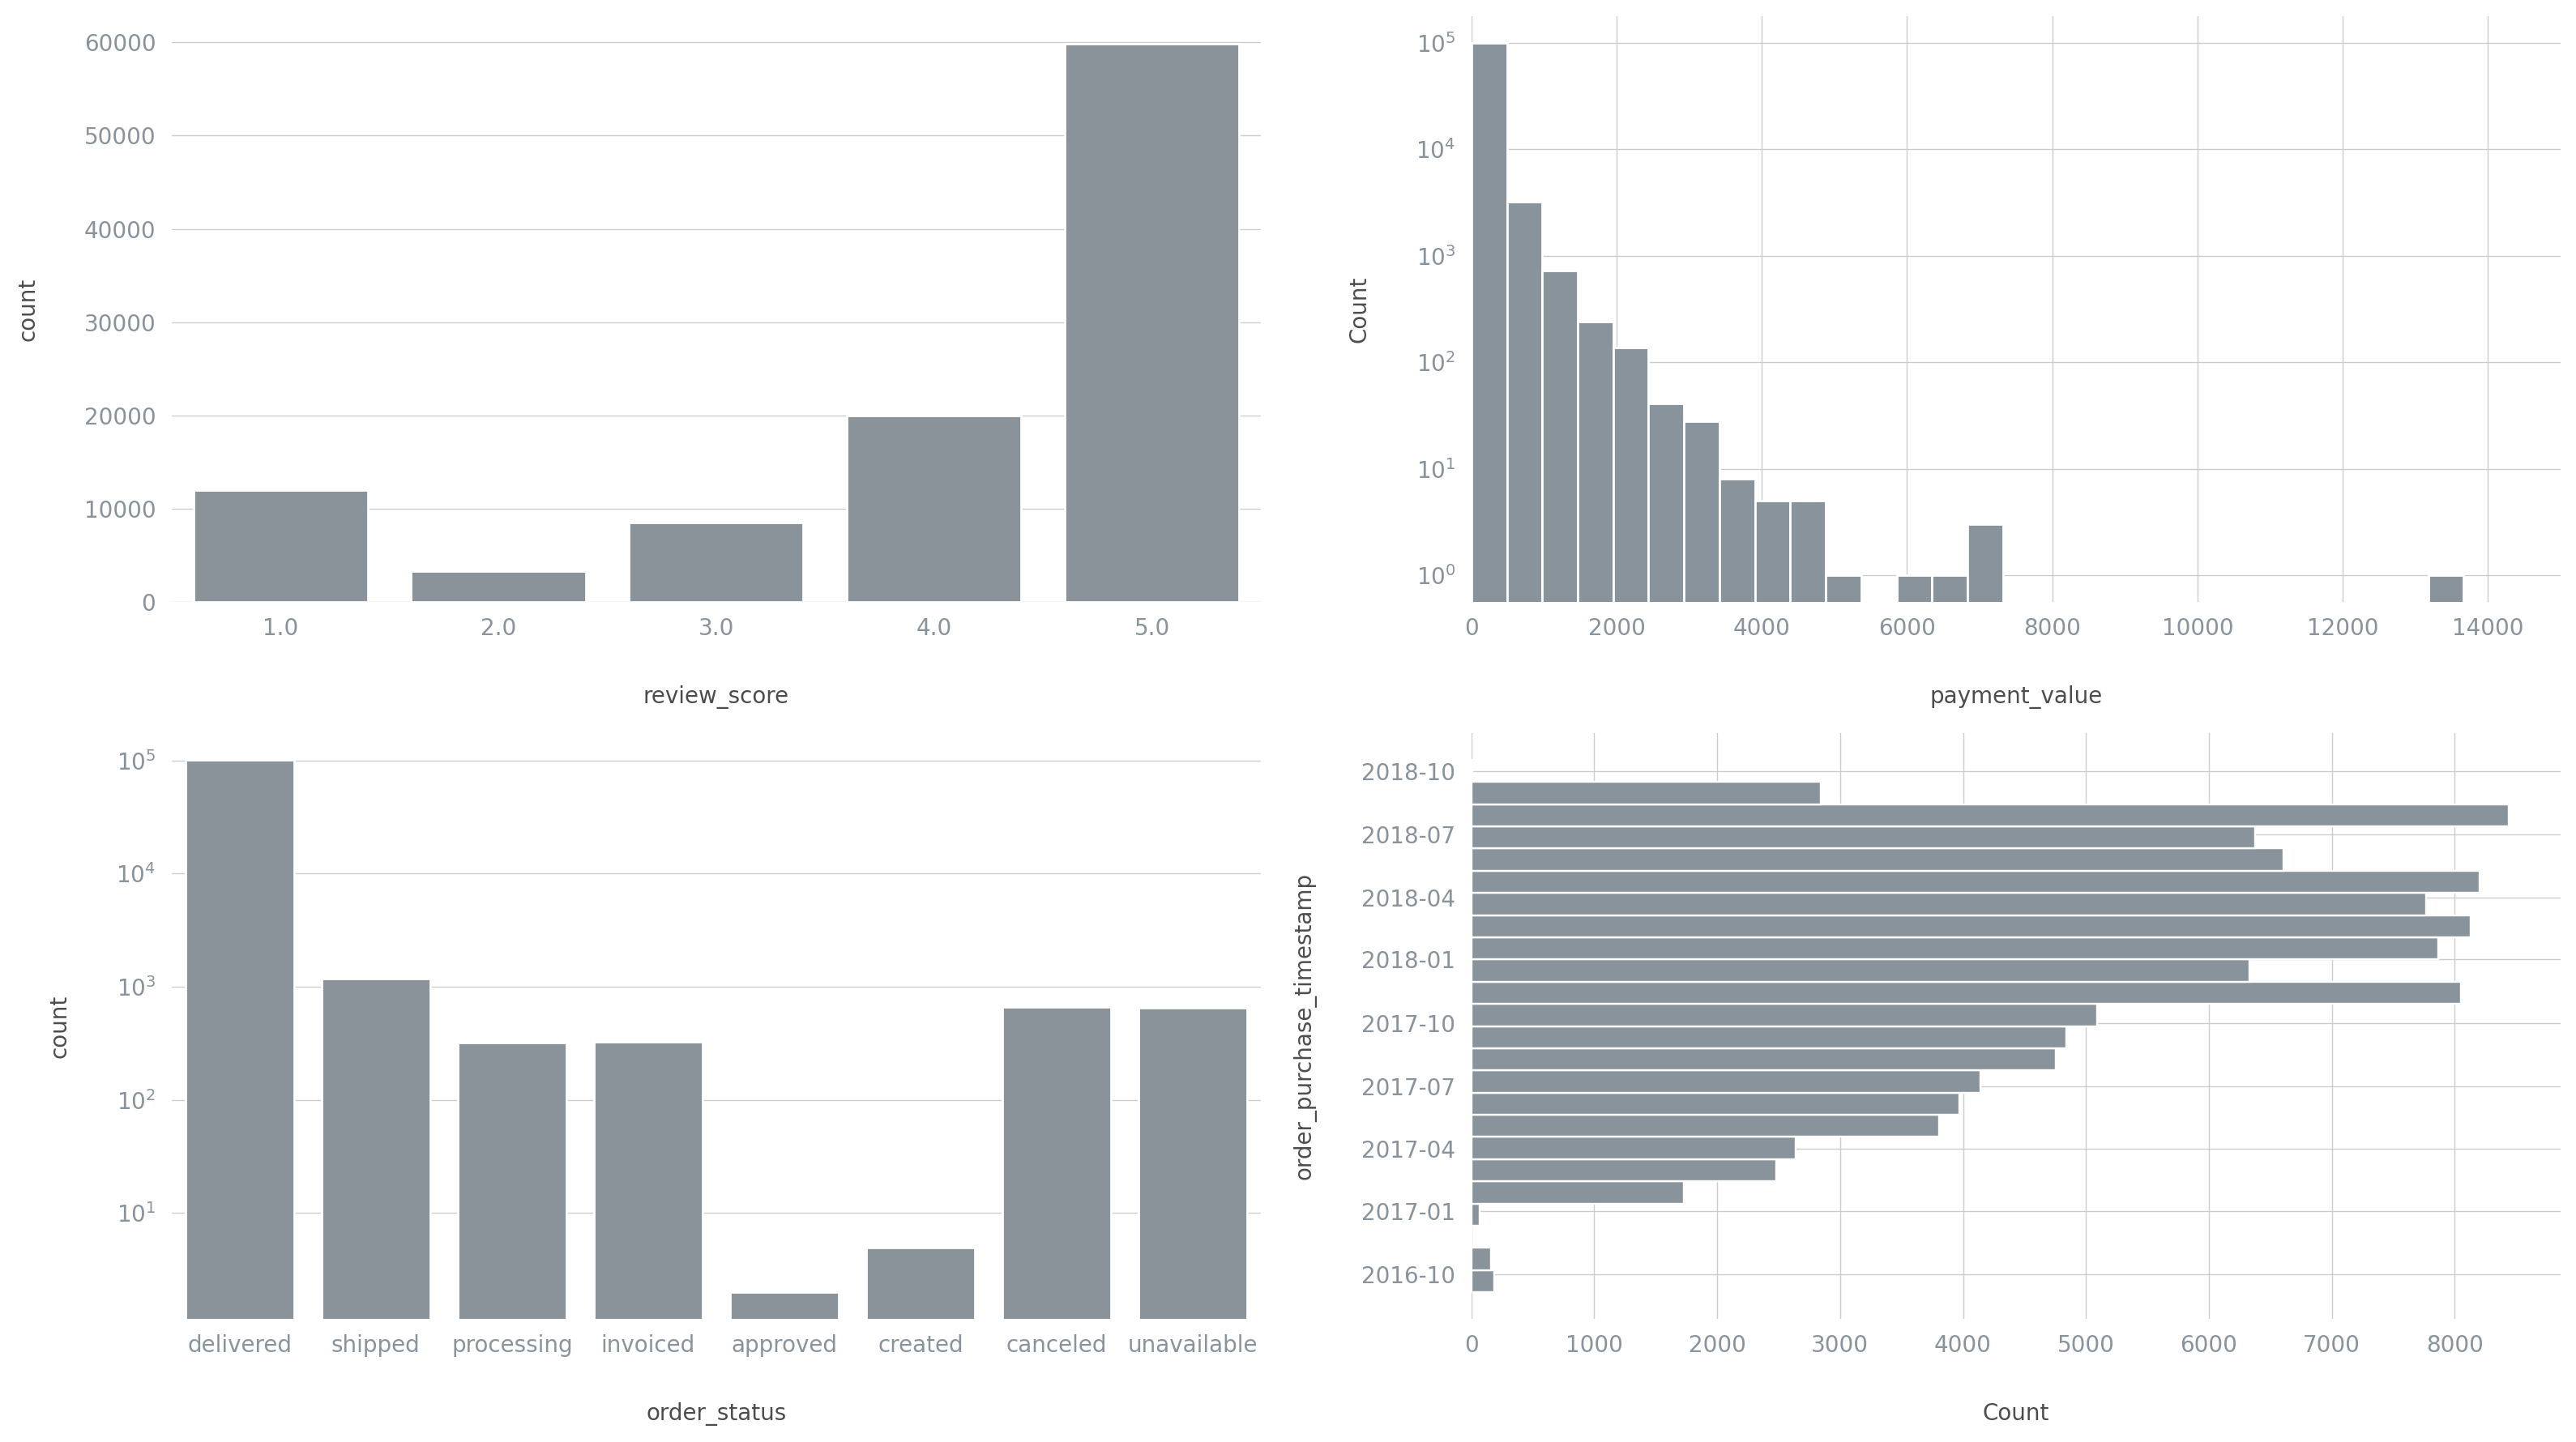

In [12]:
fig = plt.figure(figsize=(16, 9))

# Distribution of review scores
fig.add_subplot(221)
sns.countplot(data=df, x="review_score", color="#89939C")

# Distribution of payment values
fig.add_subplot(222)
sns.histplot(data=df, x="payment_value", bins=28, color="#89939C", alpha=1)
plt.xlim(0, 15000)
plt.yscale("log")

# Distribution of order status
fig.add_subplot(223)
sns.countplot(
    data=df,
    x="order_status",
    color="#89939C",
    order=[
        "delivered", "shipped", "processing", "invoiced",
        "approved", "created", "canceled", "unavailable",
    ],
)
plt.yscale("log")

# Distribution of order purchase timestamp
fig.add_subplot(224)
sns.histplot(
    data=df, y="order_purchase_timestamp", bins=24, color="#89939C", alpha=1
)

plt.tight_layout()

# Feature Engineering

### Missing payment imputation

In [10]:
# Check for missing paymentvalues and fill them with 0
df.loc[df["payment_value"].isna(), "payment_value"] = 0

### Delay

In [11]:
NOW = df["order_purchase_timestamp"].value_counts() \
                                    .sort_index(ascending=False).index[0]

In [12]:
# Delay = time between the estimated delivery date 
# and the actual delivery date
df["delay"] = (
    df["order_delivered_customer_date"] - df["order_estimated_delivery_date"]
)

# Delay pending = time between now and the estimated delivery date,
# or 0 if the estimated delivery date is in the future
delay_pending = (NOW - df["order_estimated_delivery_date"]).where(
    NOW - df["order_estimated_delivery_date"] > pd.Timedelta(0),
    pd.Timedelta(0)
)

# Flag orders not yet delivered
mask_pending = pd.isnull(df["order_delivered_customer_date"])
df.loc[mask_pending, "delay"] = df["delay"].combine_first(delay_pending)

# Delay = 0 for canceled and unavailable orders
mask_canceled = df["order_status"].isin(["canceled", "unavailable"])
df.loc[mask_canceled, "delay"] = pd.Timedelta(0)

### Time since order

In [13]:
df["time_since_order"] = NOW - df["order_purchase_timestamp"]

In [14]:
df

,order_id,order_status,order_purchase_timestamp,order_delivered_customer_date,order_estimated_delivery_date,payment_value,review_score,customer_unique_id,delay,time_since_order
0,5f79b5b0931d63f1a42989eb65b9da6e,delivered,2017-11-14 16:08:26,2017-11-28 15:41:30,2017-12-04,114.74,1.0,248ffe10d632bebe4f7267f1f44844c9,-6 days +15:41:30,337 days 01:21:52
1,a44895d095d7e0702b6a162fa2dbeced,delivered,2017-07-16 09:40:32,2017-07-25 18:57:33,2017-08-04,67.41,4.0,b0015e09bb4b6e47c52844fab5fb6638,-10 days +18:57:33,458 days 07:49:46
2,316a104623542e4d75189bb372bc5f8d,delivered,2017-02-28 11:06:43,2017-03-06 08:57:49,2017-03-22,195.42,5.0,94b11d37cd61cb2994a194d11f89682b,-16 days +08:57:49,596 days 06:23:35
3,5825ce2e88d5346438686b0bba99e5ee,delivered,2017-08-16 13:09:20,2017-09-13 20:06:02,2017-09-14,179.35,5.0,4893ad4ea28b2c5b3ddf4e82e79db9e6,-1 days +20:06:02,427 days 04:20:58
4,0ab7fb08086d4af9141453c91878ed7a,delivered,2018-04-02 13:42:17,2018-04-13 20:21:08,2018-04-18,107.01,4.0,0b83f73b19c2019e182fd552c048a22c,-5 days +20:21:08,198 days 03:48:01
...,...,...,...,...,...,...,...,...,...,...
104473,814d6a3a7c0b32b2ad929ac6328124e9,delivered,2018-03-29 16:59:26,2018-04-10 17:20:49,2018-04-27,71.23,3.0,e5794df8573fa179a90a7b797fc4b71f,-17 days +17:20:49,202 days 00:30:52
104474,8c855550908247a7eff50281b92167a8,delivered,2018-05-22 13:36:02,2018-06-08 18:03:31,2018-06-29,63.13,4.0,afbb5a642107cf6bb1ca68e863175f03,-21 days +18:03:31,148 days 03:54:16
104475,83b5fc912b2862c5046555ded1483ae9,delivered,2018-06-13 16:57:05,2018-06-18 18:33:05,2018-06-25,214.13,5.0,680213db6ebd9e4f24d03280cbe10346,-7 days +18:33:05,126 days 00:33:13
104476,d0e7be325a1c986babc4e1cdb91edc03,delivered,2017-09-02 11:53:32,2017-09-14 19:47:40,2017-09-26,45.50,5.0,48fd7dec70f2b104a1d5e8c5c639102b,-12 days +19:47:40,410 days 05:36:46


## Group by "order_id"

In [15]:
# Group data by order_id so that each row represents a different order
df_agg_order = df.groupby("order_id").agg(
    {
        "customer_unique_id": "first",  # Get the first value of customer_unique_id
        "payment_value": "sum",         # Sum the payment values
        "review_score": "mean",         # Get the mean review score
        "time_since_order": "first",    # Get the first value of time_since_order
        "delay": "max",                 # Get the max delay
    }
).reset_index().sort_values("time_since_order") # Sort by recency

df_agg_order.columns = [
    "order_id",
    "customer_unique_id",
    "total_payments",
    "mean_review_score",
    "time_since_order",
    "delay",
]

In [21]:
# Save to JSON
df_agg_order.to_json(data_path / "json" / "orders.json")

## Group by "customer_id"

In [43]:
imputer = SimpleImputer(strategy="mean")
scaler = StandardScaler()

df_preprocessed = customer_preprocessing(df_agg_order, imputer, scaler)
df_preprocessed.head()

,n_orders,total_payments,mean_review_score,time_since_order,mean_delay
customer_unique_id,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,-0.173593,0.278509,0.684576,-0.833865,0.025207
0000b849f77a49e4a4ce2b2a4ca5be3f,-0.173593,-1.715381,-0.063565,-0.814378,0.022821
0000f46a3911fa3c0805444483337064,-0.173593,-0.327960,-0.811705,1.940152,0.082023
0000f6ccb0745a6a4b88665a16c9f078,-0.173593,-1.151287,-0.063565,0.532372,-0.119279
0004aac84e0df4da2b147fca70cf8255,-0.173593,0.678430,0.684576,0.317469,-0.034910


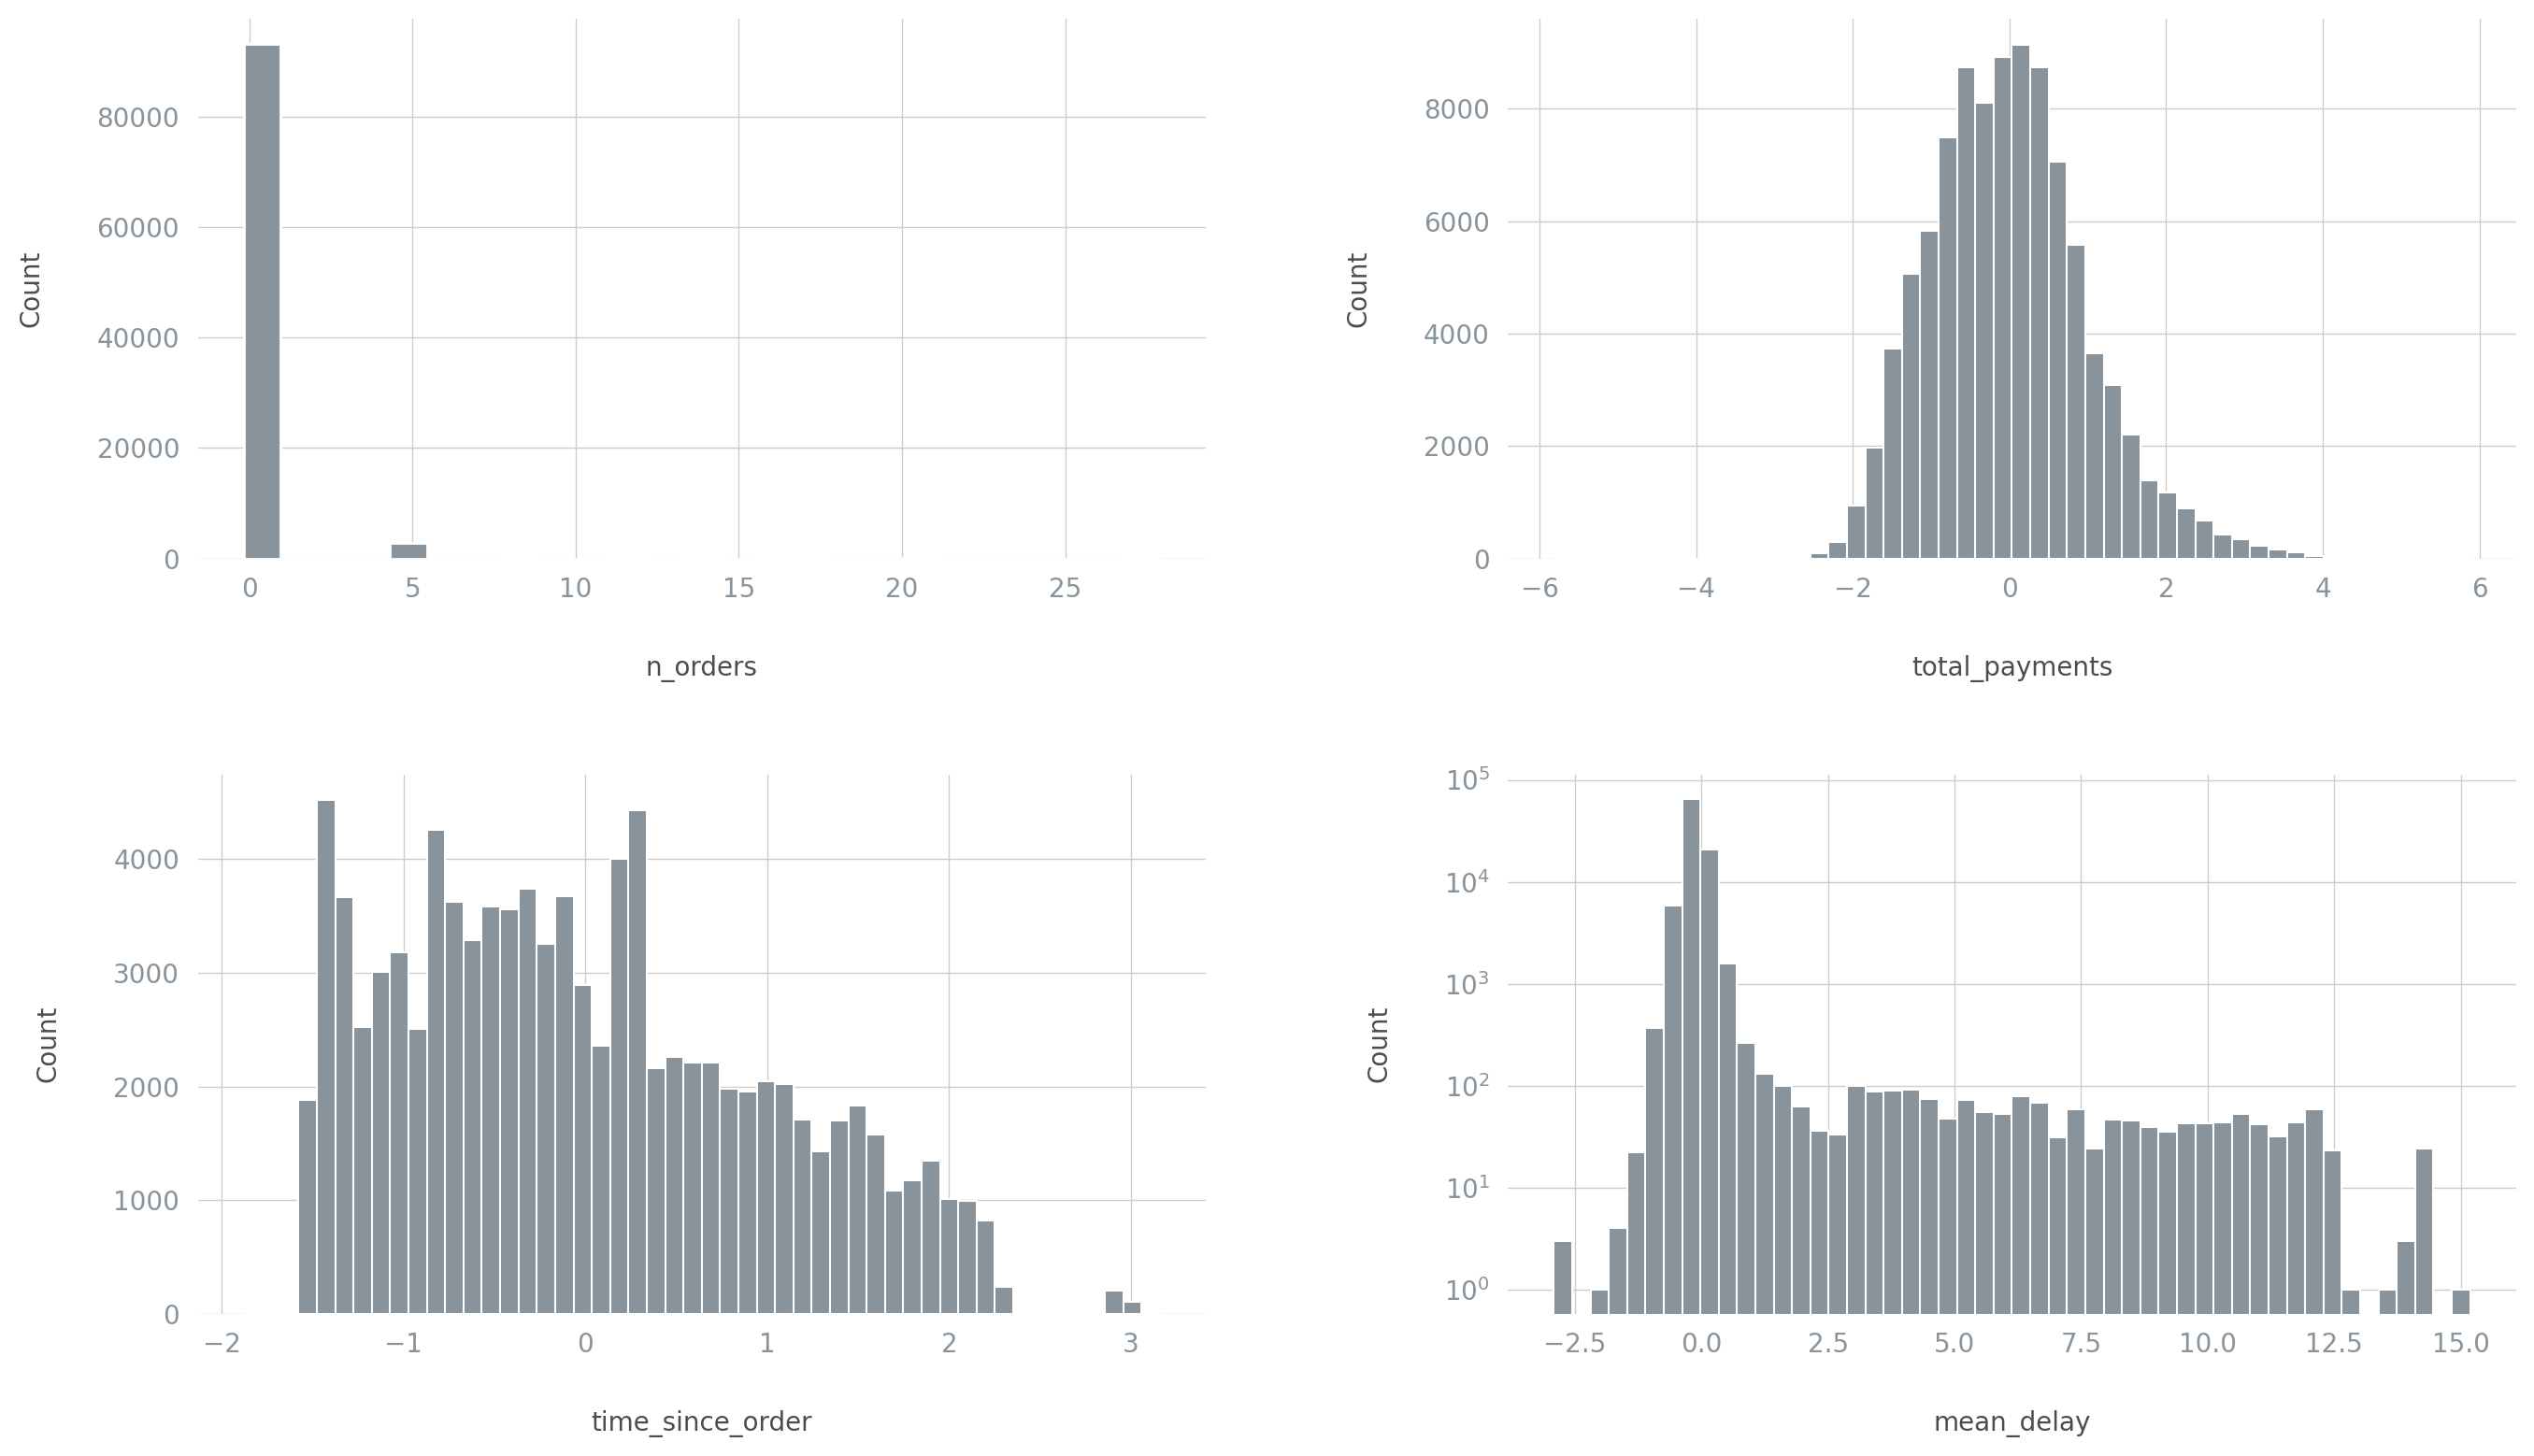

In [44]:
fig = plt.figure(figsize=(16, 9))

# Distribution of the standardized number of orders
fig.add_subplot(221)
sns.histplot(
    df_preprocessed["n_orders"], bins=25, color="#89939C", alpha=1
)

# Distribution of the standardized total payments
fig.add_subplot(222)
sns.histplot(
    df_preprocessed["total_payments"], bins=50, color="#89939C", alpha=1
)

# Distribution of the standardized time since order
fig.add_subplot(223)
sns.histplot(
    df_preprocessed["time_since_order"], bins=50, color="#89939C", alpha=1
)

# Distribution of the standardized mean delay
fig.add_subplot(224)
sns.histplot(
    df_preprocessed["mean_delay"], bins=50, color="#89939C", alpha=1
    )
plt.yscale("log")

# Adjust the space between subplots
plt.subplots_adjust(wspace=0.3, hspace=0.4)

In [ ]:
# Save to JSON
df_preprocessed.to_json("data.json")